In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg19 import VGG19
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.models import Model
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [4]:
# Change the integer-encoding to one-hot-encoding
# So that model don't assume a natural ordering between categories
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

train_labels = train_labels.astype('float32')
test_labels = test_labels.astype('float32')

In [5]:
print("Train Images Shape : " + str(train_images.shape))
print("Test Images Shape : " + str(test_images.shape))
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

Train Images Shape : (50000, 32, 32, 3)
Test Images Shape : (10000, 32, 32, 3)


In [6]:
# The classes in CIFAR-10 dataset
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
vgg19 = VGG19(weights="imagenet", include_top=False, input_shape=(32,32, 3))
vgg19.trainable = False

80150528/80134624 [==============================] - 1s 0us/step


In [8]:
x = vgg19.output
x = GlobalAveragePooling2D()(x)

x = BatchNormalization()(x)

x = Dropout(0.5)(x) 
x = Dense(512, activation ='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(10, activation ='softmax')(x)

model = Model(vgg19.input, x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [9]:
earlystop_callback = EarlyStopping(
  monitor='val_loss', min_delta=0, patience=4)

In [10]:
model.compile(optimizer ='Adam', 
              loss ="categorical_crossentropy", 
              metrics =["accuracy"]) 

In [11]:
history = model.fit(train_images,train_labels, epochs = 5, validation_data = (test_images,test_labels), verbose = 1, batch_size=256,shuffle=True)
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

Epoch 1/5
196/196 [==============================] - 769s 4s/step - loss: 1.9539 - accuracy: 0.3880 - val_loss: 1.4915 - val_accuracy: 0.5052
Epoch 2/5
196/196 [==============================] - 769s 4s/step - loss: 1.5836 - accuracy: 0.4493 - val_loss: 1.3514 - val_accuracy: 0.5301
Epoch 3/5
196/196 [==============================] - 768s 4s/step - loss: 1.5050 - accuracy: 0.4704 - val_loss: 1.3120 - val_accuracy: 0.5405
Epoch 4/5
196/196 [==============================] - 768s 4s/step - loss: 1.4716 - accuracy: 0.4800 - val_loss: 1.2848 - val_accuracy: 0.5437
Epoch 5/5
313/313 [==============================] - 135s 431ms/step - loss: 1.2762 - accuracy: 0.5481
Test accuracy: 54.81%


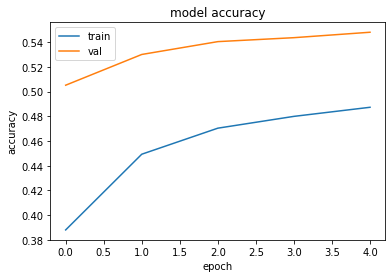

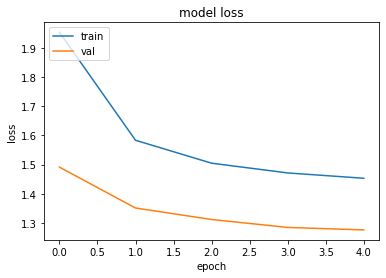

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
model.save('transfer_model.h5')

In [ ]:
"""
Run this cell, by replacing "<IMAGE_PATH_HERE>" with your image path to test a custom image
"""
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('transfer_model.h5')

def test(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (32, 32))
    img = img / 255.0
    res = model.predict(np.array([img]))
    ans = np.argmax(res)
    print(class_names[ans])

test("<IMAGE_PATH_HERE>")